# Laboratorium 13 - Minimalizacja funkcji

##### Aleksandra Mazur

## Zadanie 1 Problem komiwojażera

#### Wygeneruj chmurę n losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.

#### a) Przedstaw wizualizacje otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 róznych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema różnymi grupami parametrów, dziewięć odseparowanych grup punktów).
#### b) Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap - zamiana kolejności losowej pary połączonych wierzchołków w scieżce vs. arbitrary swap - zamiana dwóch losowych wierzchołków w scieżce) oraz początkowej wartości temperatury na zbieżność procesu optymalizacji.
#### c) Przedstaw wizualizacje działania procedury minimalizującej funkcje celu (funkcja przekazana do metody dual annealing może modyfikować zewnętrzny stan)

Do rozwiązania zadania użyto następujących funkcji:
* numpy
* random
* matplotlib
* math
* scipy

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from scipy.optimize import dual_annealing

Zastosowano algorytm wyżarzania do przybliżonego rozwiązania problemu komiwojażera (TSP). 

Problem komiwojażera to zagadnienie optymalizacyjne, polegające na znalezieniu minimalnego cyklu Hamiltona w pełnym grafie ważonym. W tym przypadku sprowadza się on do znalezienia cyklu przechodzącego przez wszystkie wierzchołki o najkrótszej ścieżce.

Z kolei algorytm symulowanego wyżarzania opiera się na ciągłym ulepszaniu istniejącego rozwiązania do momentu, gdy nie udaje się go dalej poprawić. Przejście z jednego rozwiązania do drugiego jest realizowane przez tzw. funkcję przejścia i polega na znalezieniu rozwiązania sąsiedniego, co jest zależne od problemu, w którym algorytm jest zastosowany.

Ścieżka była reprezentowana przez tablicę wierzchołków (sąsiedztwo dwóch wierzchołków w tablicy oznacza, że jest między nimi krawędź, istnieje także krawędź między pierwszym i ostatnim wierzchołkiem w tablicy). Generacja stanu sąsiedniego została przetestowana w dwóch wariantach: w pierwszym, *consecutive swap*, zamieniano sąsiednie wierzchołki miejscami. W drugim wariancie, *abribtrary swap*, wierzchołki do zamiany były wybierane losowo.

Program przetestowano dla trzech rozkładów punktów na płasczyźnie: rozkład jednostajny, rozkład normalny, 9 grup wierzchołków. W każdym z rozkładów rozpatrzono 3 różne liczby wierzchołków.

Wykonano także wykresy zależności energii w zależności od liczby iteracji pętli algorytmu wyżarzania.

Poniższe funkcje generują *n* losowych punktów w 2D:
* **generate_uniform** - punkty o rozkładzie jednostajnym
* **generate_normal** - punkty o rozkładzie normalnym z wartością oczekiwaną *m* i odchyleniem standardowym *sigma*
* **generate_nine** - dziewięć odseparowanych grup punktów

In [21]:
def generate_uniform(n, low=0, high=50):
    points = []
    for i in range(n):
        points.append([np.random.uniform(low, high), np.random.uniform(low, high)])
    random.shuffle(points)
    return np.array(points)

def generate_normal(n):
    points = []
    mu = [0, 2, 10, 20]
    sigma = [10, 12, 20, 50]
    for i in range(4):
        for j in range(int(n/4)):
            points.append([np.random.normal(mu[i], sigma[i]), np.random.normal(mu[i], sigma[i])])
            
    while len(points) != n:
        i = random.randint(0, 3)
        points.append([np.random.normal(mu[i], sigma[i]), np.random.normal(mu[i], sigma[i])])

    random.shuffle(points)
    return np.array(points)

def generate_nine(n):
    pairs = [[1,2], [4,5], [7,8]]
    points = []
    for x in pairs:
        for y in pairs:
            for i in range(int(n/9)):
                points.append([np.random.uniform(x[0], x[1]), np.random.uniform(y[0], y[1])])
    
    if len(points) != n:
        for x in pairs:
            for y in pairs:
                for i in range(int(n/9)):
                    points.append([np.random.uniform(x[0], x[1]), np.random.uniform(y[0], y[1])])
                    if len(points) == n:
                        random.shuffle(points)
                        return np.array(points)
    
    random.shuffle(points)
    return np.array(points)        

Funkcje zamieniające kolejność punktów (wierzchołków) z tablicy *x*:
* **consecutive_swap** - zamienia kolejnością losową parę punktów, które ze sobą sąsiadują
* **arbitrary_swap** - zamienia dwa losowe wierzchołki

In [3]:
def consecutive_swap(x):
    i = random.randint(0, len(x) - 2)
    x[i], x[i + 1] = x[i + 1], x[i]
    return x

def arbitrary_swap(x):
    i = random.randint(0, len(x) - 1)
    j = random.randint(0, len(x) - 1)
    while i == j:
        i = random.randint(0, len(x) - 1)
        
    x[i], x[j] = x[j], x[i]
    return x

Funkcje pomocnicze:
* **distance** - oblicza odległość między dwoma punktami *p* i *q*
* **sort_by_value** - indeksuje tablicę x, a następnie sortuje ją względem wartości, zachowując w pamięci indeksy początkowego ułożenia

In [4]:
def distance(p, q):
    return np.sqrt((p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2)

def sort_by_value(x):
    x_indexes = []
    
    for (i, val) in enumerate(x):
        x_indexes.append([i, val])
    x_indexes.sort(key=lambda element: element[1])
    
    return x_indexes

Funkcja **count_energy** oblicza długość ścieżki złożonej z punktów znajdujących się w globalnej tablicy *points* ułożonych w kolejności zdefiniowanej w macierzy *x_indexes*. Dodatkowo funkcja ta zapisuje do globalnej tablicy *energies* obliczoną długość ścieżki w celu późniejszej wizualizacji.

Przykładowo jeżeli macierz x_indexes i points mają postać 

x_indexes = [[3, 0.123], [0, 3.456], [2, 4.123], [1, 5.9]]

points = [[1,2], [5,3], [2,2], [4,6]]

To funkcja ta obliczy odległość między następującą sekwencją punktów (nie zmieniając oryginalnej tablicy *points*):
[[4,6], [1,2], [2,2], [5,3]]
uwzględniając połączenie między ostatnim i pierwszym punktem

In [5]:
def count_energy(x_indexes):
    energy = 0
    N = len(x_indexes)
    for k in range(N):
        i = x_indexes[k][0]
        j = x_indexes[(k + 1) % N][0]
        energy += distance(points[i], points[j])
    energies.append(energy)
    return energy

Poniższe funkcje są funkcjami przekazywanymi do funkcji bibliotecznej *dual_annealing*.
* **f_consecutive** wykorzystuje consecutive_swap
* **f_arbitrary** wykorzystuje arbitrary_swap

Funkcje te przyjmują wektor x, wykonują zamianę losowych punktów wykorzystując odpowiednią metodę, indeksują i sortują wektor *x* po wartości i zwracają odległość między punktami tablicy globalnej *points* ułożonymi w kolejności przedstawionej w macierzy *x_indexes*.

Funkcja **f** nie zamienia otrzymanych punktów.

In [6]:
def f_consecutive(x):
    x = consecutive_swap(x)
    x_indexes = sort_by_value(x)
    return count_energy(x_indexes)

def f_arbitrary(x):
    x = arbitrary_swap(x)
    x_indexes = sort_by_value(x)
    return count_energy(x_indexes)

def f(x):
    x_indexes = sort_by_value(x)
    return count_energy(x_indexes)

Funkcja **show_result** przyjmuje macierz *x_indexes* otrzymaną jako rezultat funkcji *dual_annealing* i zmienne informacyjne. Jest w niej zawarte optymalne ułożenie punktów *points*, jakie wybrała funkcja biblioteczna. Na tej podstawie jest przedstawiona wizualizacja uzyskanej ścieżki. Dodatkowo przedstawiono na wykresie ścieżkę losową przechodzącą przez wszystkie punkty. Dla obu przypadków wypisano również długość ścieżek. Funkcja ta przedstawia też na wykresie wizualizację działania procedury minimalizującej, czyli kolejne długości ścieżek obliczane przez funkcję *dual_annealing*.

In [7]:
def show_result(x_indexes, show_random, name):
    print("N = ", len(x_indexes))
    fig, ax = plt.subplots(1,2, figsize=[20,10])
    
    # Random path
    if show_random:
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        xs.append(xs[0]) # dodano na koniec pierwszy punkt
        ys.append(ys[0])

        energy_random = 0 # obliczenie długości śieżki dla losowego ułożenia punktów
        N = len(points)
        for k in range(N):
            energy_random += distance(points[k], points[(k + 1) % N])

        ax[0].plot(xs, ys, 'co')
        ax[0].plot(xs, ys, linewidth=1, color='black')
        ax[0].set_title(f'Random path, length: {energy_random}')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
    
    # TSP path
    xs = []
    ys = []
    for (i, val) in x_indexes:
        xs.append(points[i][0])
        ys.append(points[i][1])
    xs.append(xs[0])
    ys.append(ys[0])
    
    energy_TSP = 0
    N = len(points)
    for k in range(N):
        energy_TSP += distance([xs[k], ys[k]], [xs[(k + 1) % N], ys[(k + 1) % N]])
    
    if show_random:
        ax[1].plot(xs, ys, 'co')
        ax[1].plot(xs, ys, linewidth=1, color='black')
        ax[1].set_title(f'TSP {name}, length: {energy_TSP}')
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('y')
        plt.show()
        
        # Energies plot
        plt.figure(figsize=(8, 8))
        plt.plot(energies)
        plt.xlabel('Iteration')
        plt.ylabel('Energy')
        plt.title('Energies')
        plt.show()
    else:
        ax[0].plot(xs, ys, 'co')
        ax[0].plot(xs, ys, linewidth=1, color='black')
        ax[0].set_title(f'TSP {name}, length: {energy_TSP}')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
    
        # Energies plot
        ax[1].plot(energies)
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('Energy')
        ax[1].set_title('Energies')
        plt.show()

Funkcja **simulated_annealing** przyjmuje nazwę metody dokonującej zamianę punktów *swap_method* i temperaturę *temp* oraz zmienne informacyjne, wywołuje funkcje biblioteczną *dual_annealing* z odpowiednimi parametrami i wizualizuje uzyskane efekty.

Jako *bounds* w funkcji *dual_annealing* przyjęto tablicę *N* przedziałów [0,5], gdzie *N* to liczba wygenerowanych punktów.

In [8]:
def simulated_annealing(function, temp=5230.0, show_random=True, name=""):
    bounds = list(zip([0] * N, [5] * N))
    result = dual_annealing(function, 
                            bounds=bounds,
                            initial_temp=temp)
        
    x_indexes = sort_by_value(result.x)
    show_result(x_indexes, show_random, name)

## Liczba punktów: N = 10
### Rozkład jednostajny

N =  10


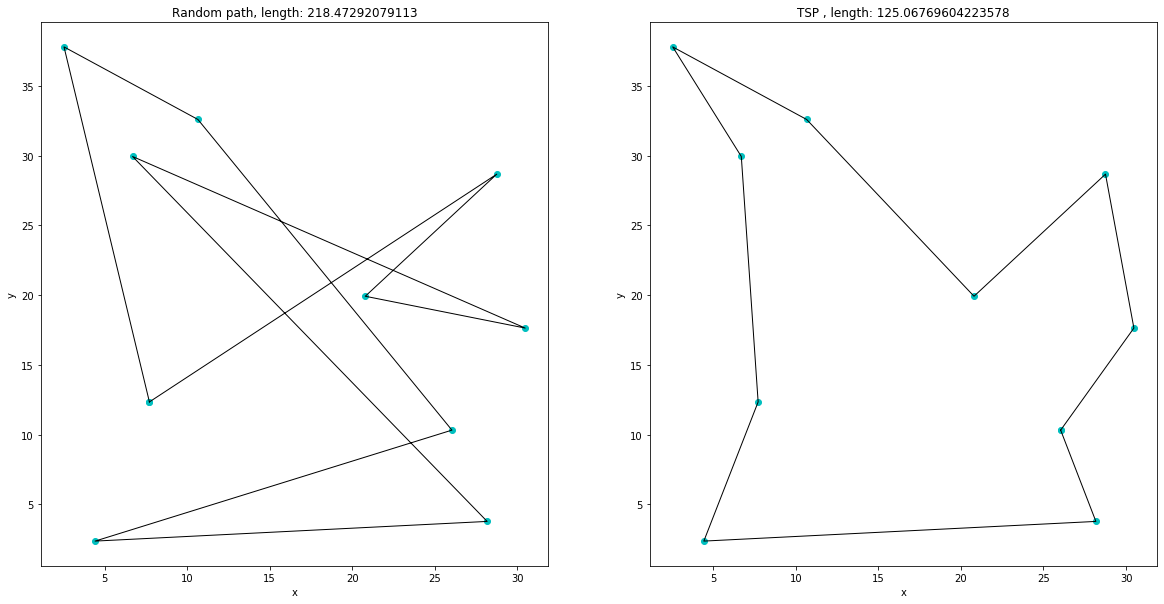

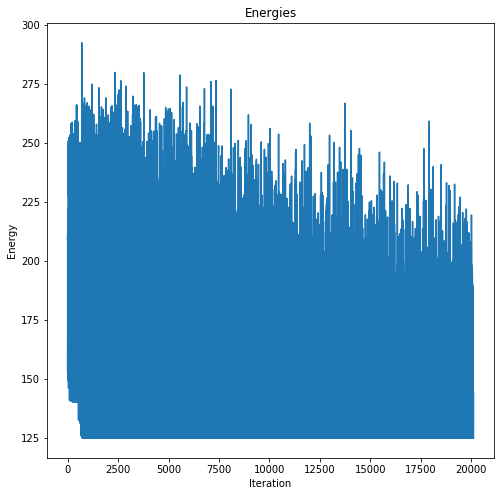

In [9]:
N = 10
points = generate_uniform(N)
energies = []
simulated_annealing(f, temp=1000)

### Rozkład normalny z czterema różnymi grupami parametrów

N =  10


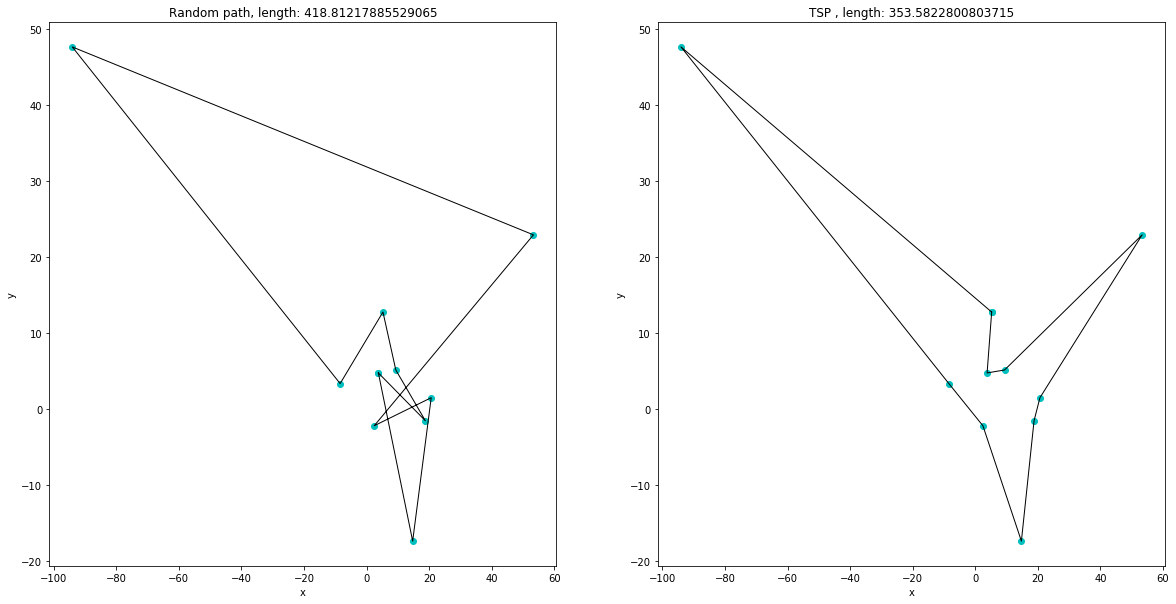

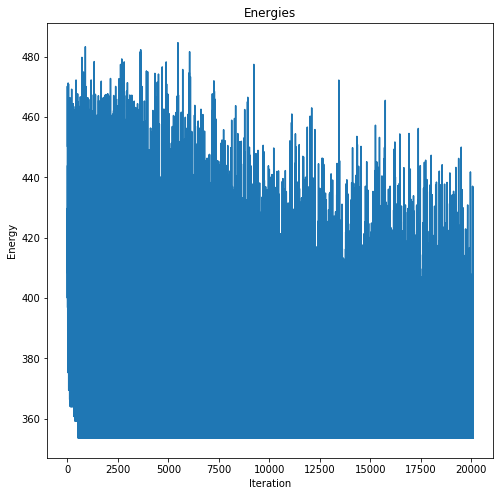

In [10]:
points = generate_normal(N)
energies = []
simulated_annealing(f, temp=1000)

### Dziewięć odseparowanych grup punktów

N =  50


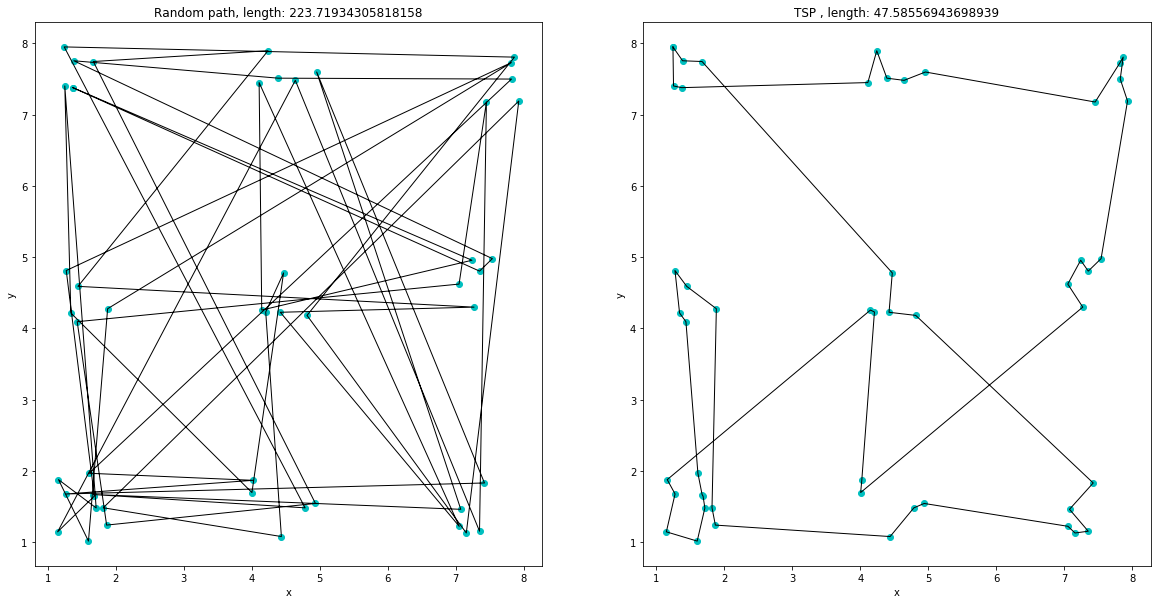

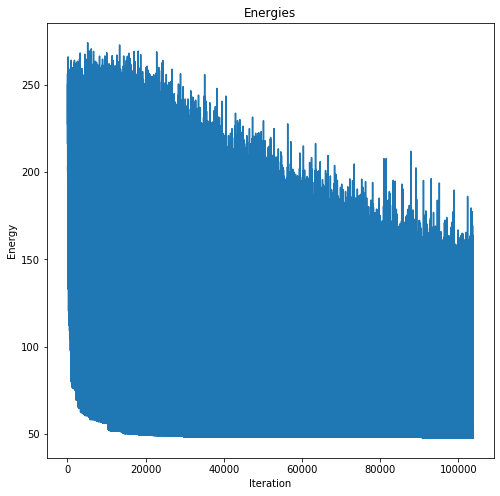

In [22]:
points = generate_nine(N)
energies = []
simulated_annealing(f, temp=1000)

## Liczba punktów: N = 25
### Rozkład jednostajny

N =  25


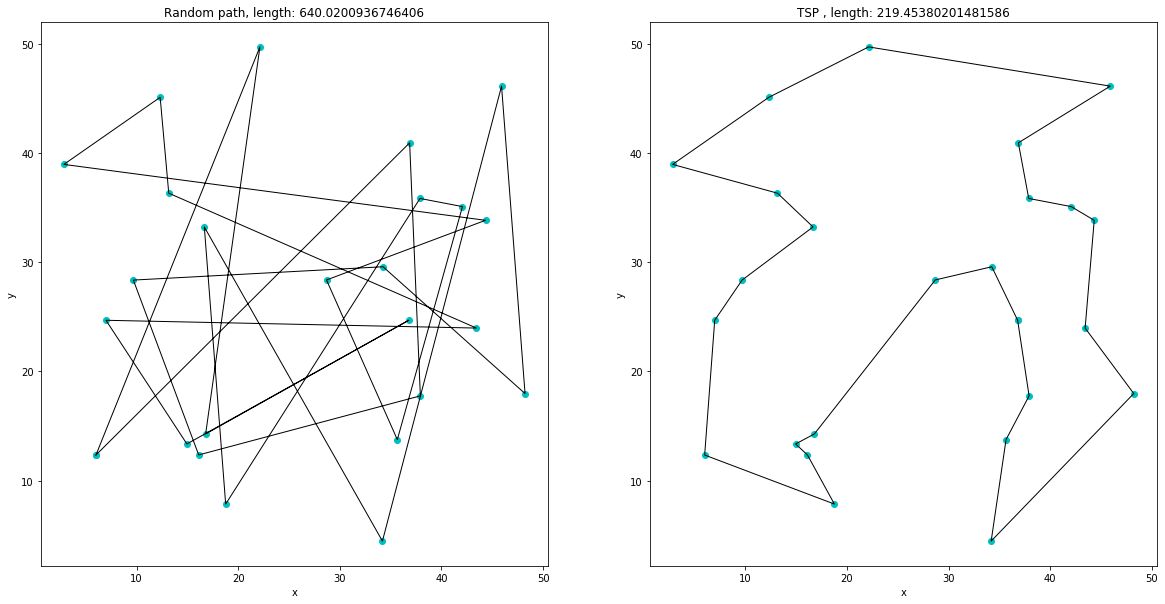

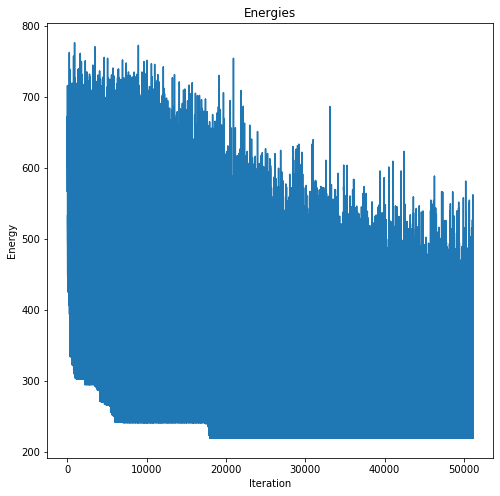

In [12]:
N = 25
points = generate_uniform(N)
energies = []
simulated_annealing(f, temp=1000)

### Rozkład normalny z czterema różnymi grupami parametrów

N =  25


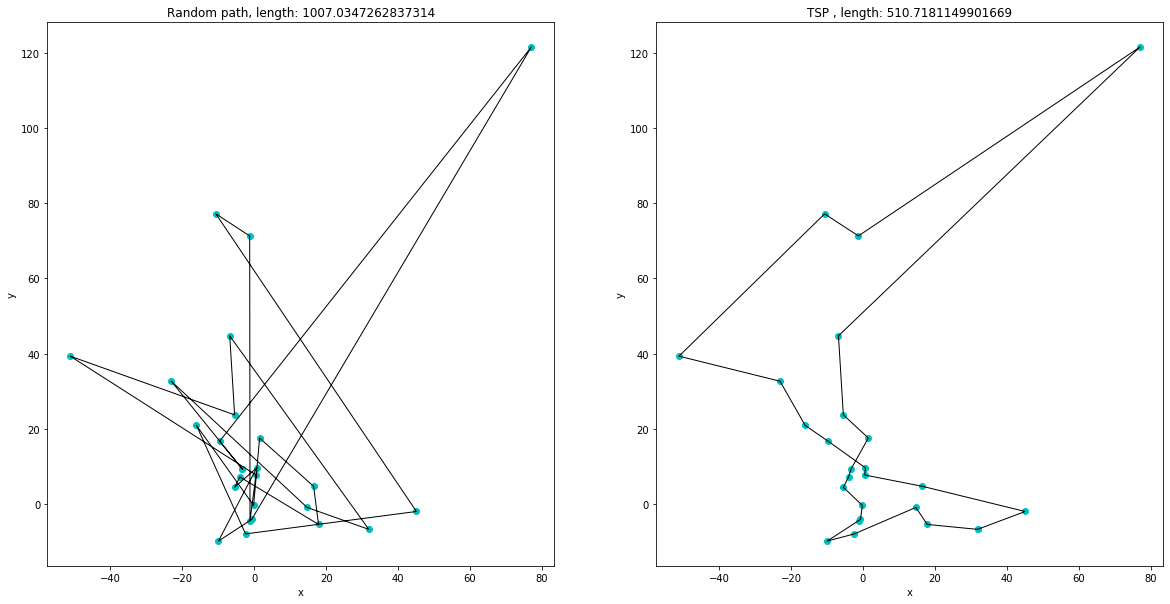

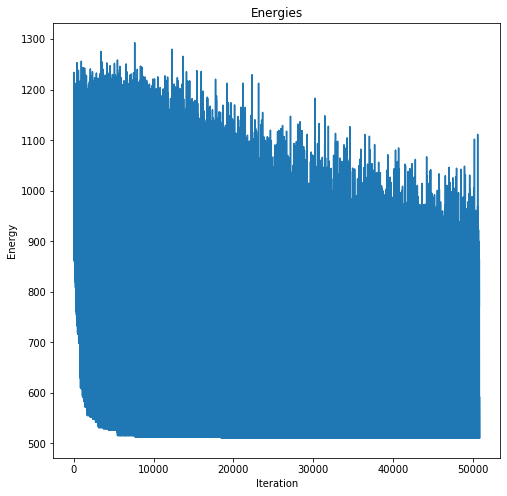

In [13]:
points = generate_normal(N)
energies = []
simulated_annealing(f, temp=1000)

### Dziewięć odseparowanych grup punktów

N =  50


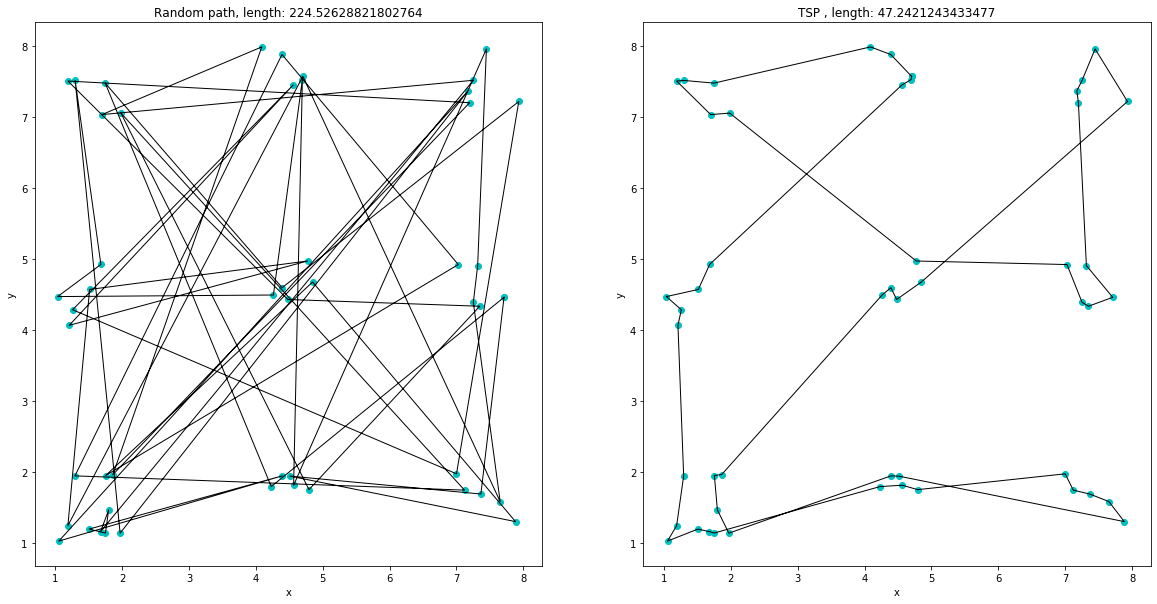

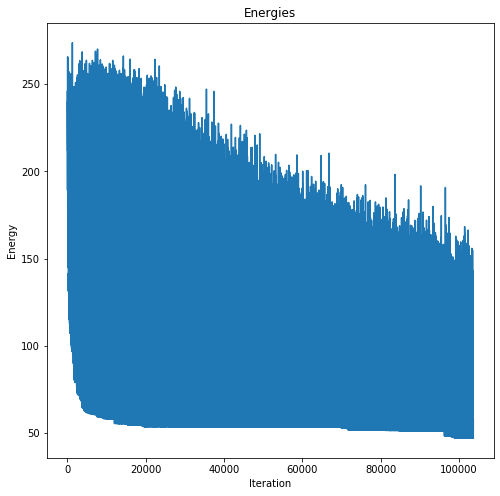

In [23]:
points = generate_nine(N)
energies = []
simulated_annealing(f, temp=1000)

## Liczba punktów: N = 50
### Rozkład jednostajny

N =  50


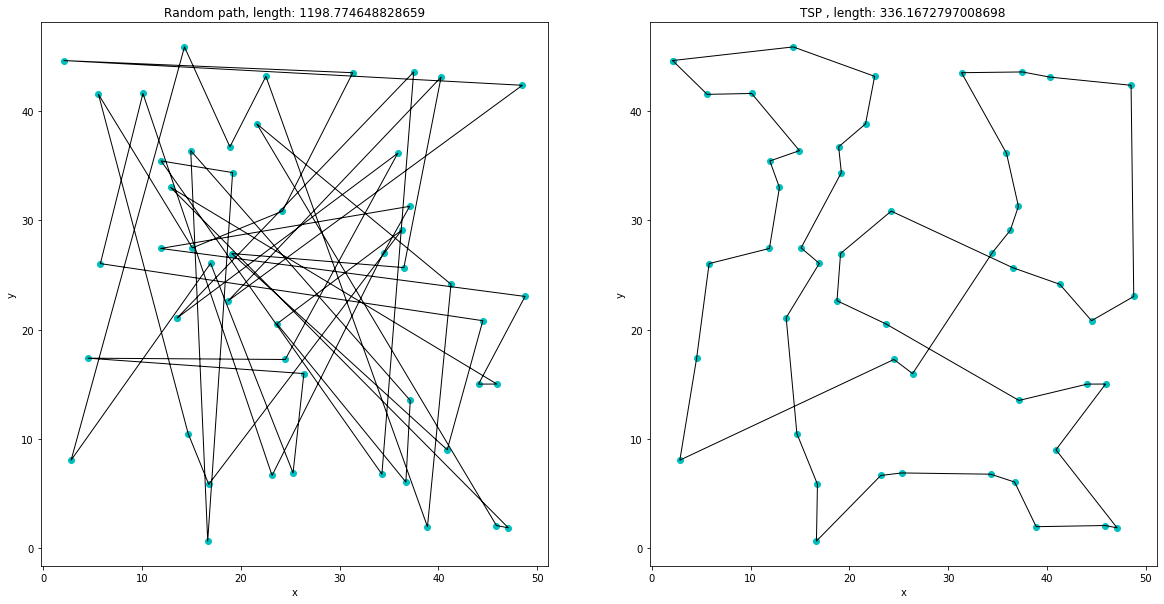

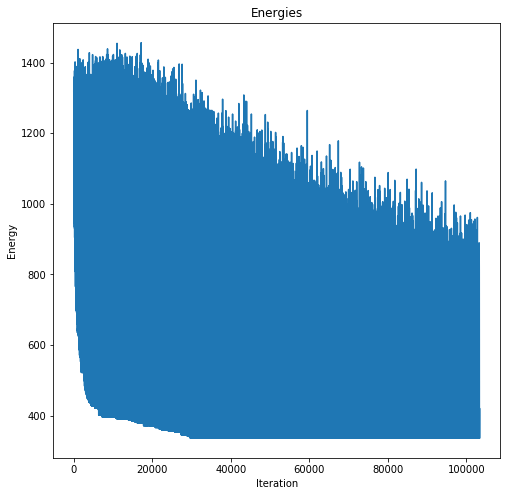

In [19]:
N = 50
points = generate_uniform(N)
energies = []
simulated_annealing(f, temp=1000)

### Rozkład normalny z czterema różnymi grupami parametrów

N =  50


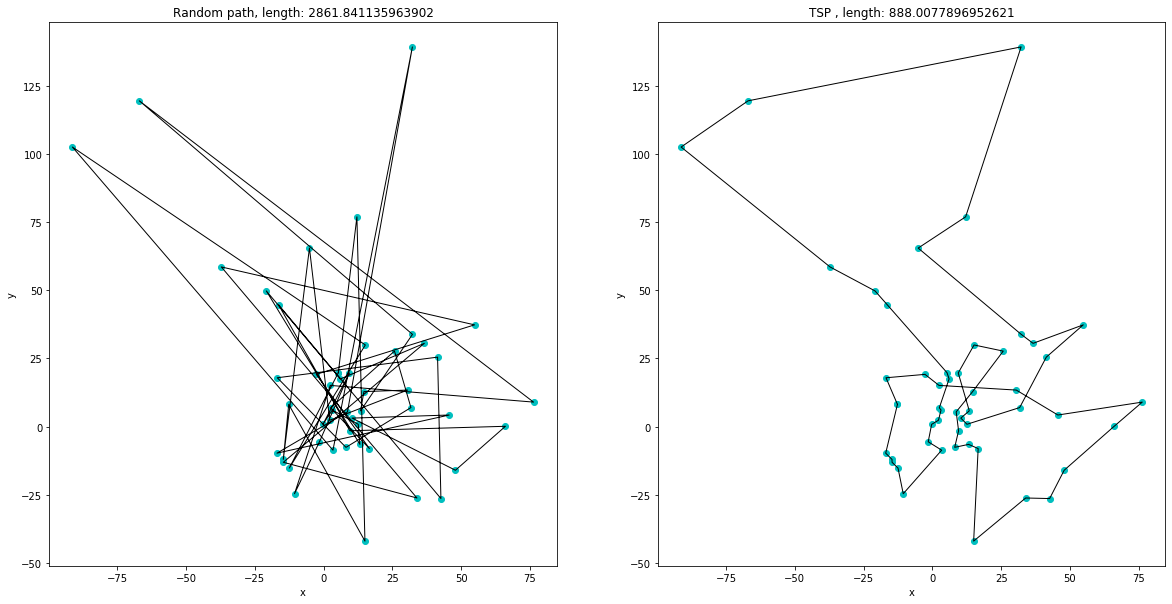

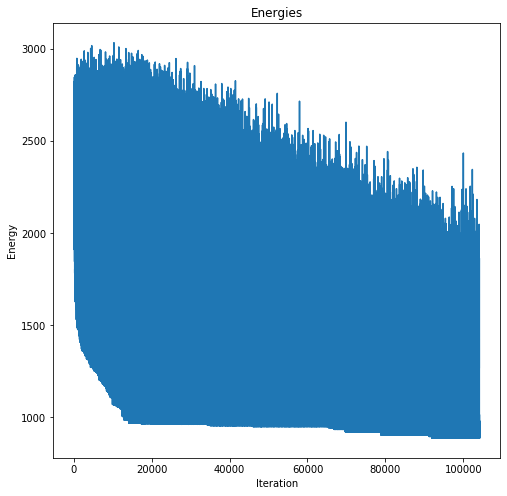

In [24]:
points = generate_normal(N)
energies = []
simulated_annealing(f, temp=1000)

### Dziewięć odseparowanych grup punktów

N =  50


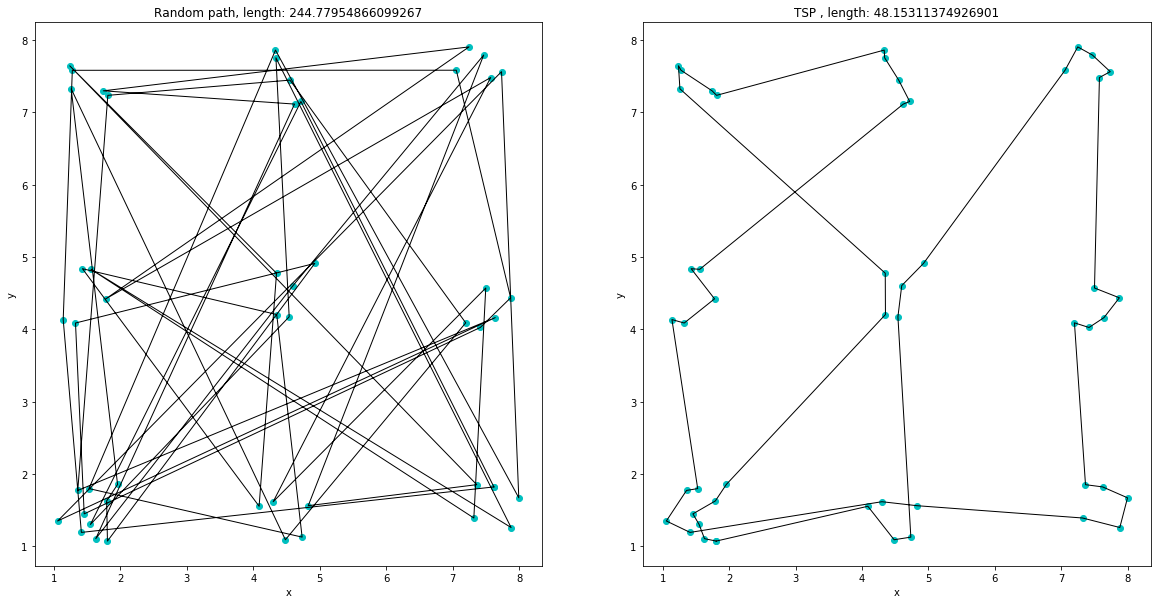

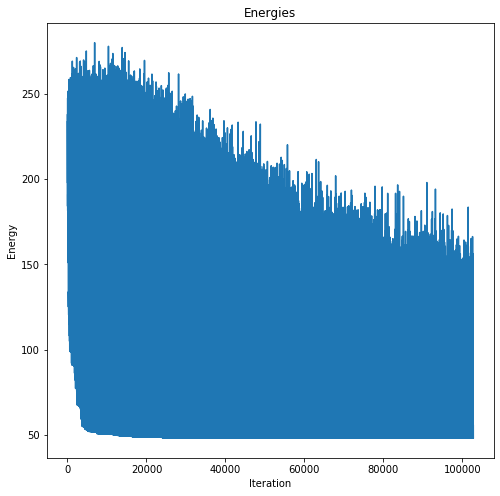

In [25]:
points = generate_nine(N)
energies = []
simulated_annealing(f, temp=1000)

## Wnioski:
W każdym przypadku długość ścieżki została zminimalizowana poprzez zastosowanie algorytmu symulowanego wyżarzania. Można zauważyć, że funkcja energii dąży do minimum, a rosnące wartości mogą oznaczać wychodzenie z lokalnych minimów. W niektórych przypadkach algorytm po znalezieniu minimum, przy dalszych iteracjach zwiększał wartość energii, co prowadziło do znalezienia mniej optymalnego rozwiązania.

## b) Wpływ sposobu generacji sąsiedniego stanu
### Dla rozkładu jednostajnego i liczby punktów N = 30

N =  30


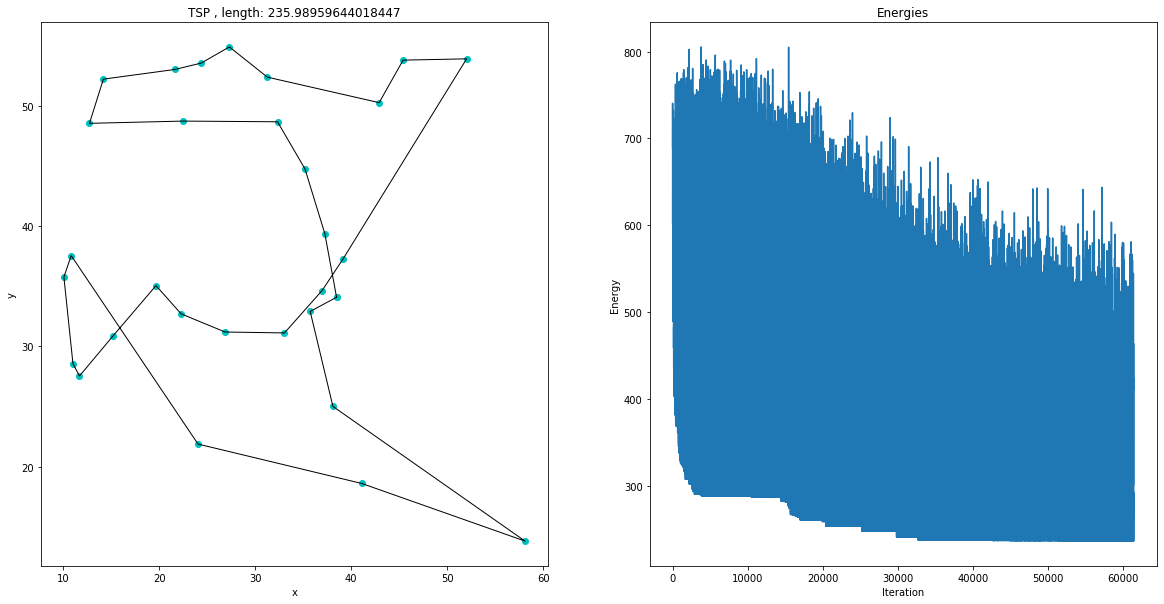

N =  30


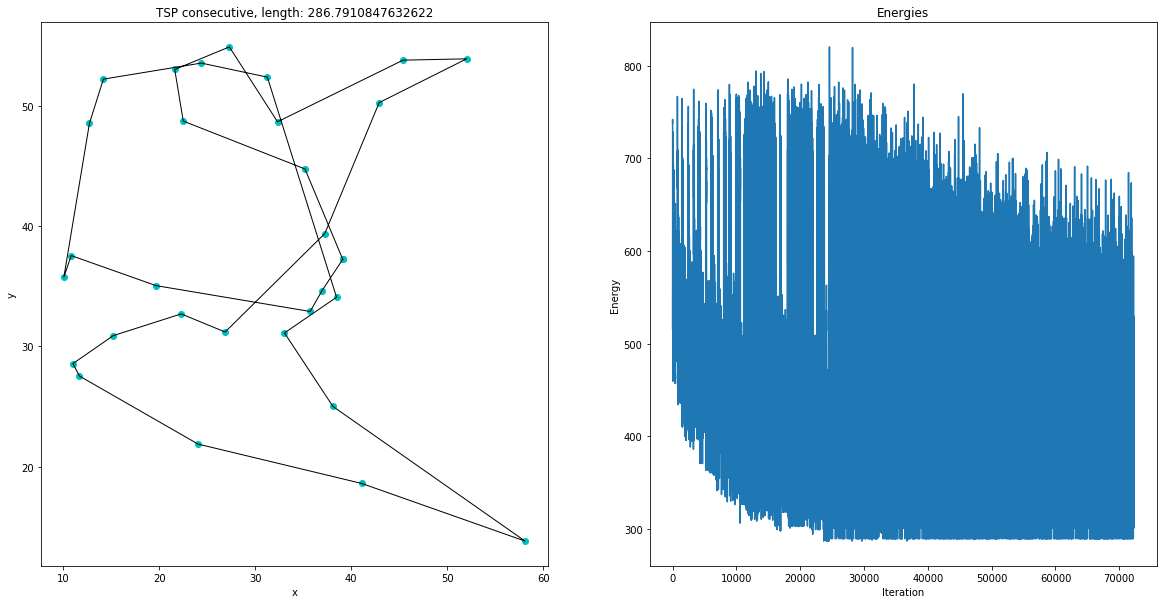

N =  30


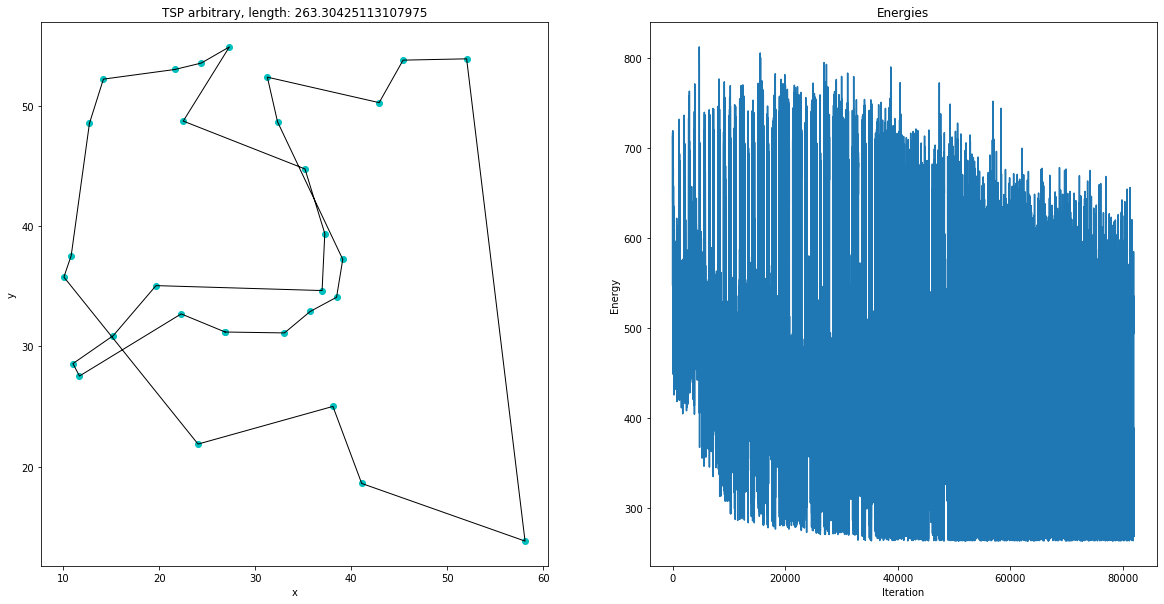

In [27]:
N = 30
points = generate_uniform(N, 10, 60)

energies = []
simulated_annealing(f, temp=1000, show_random=False, name="")

energies = []
simulated_annealing(f_consecutive, temp=1000, show_random=False, name="consecutive")

energies = []
simulated_annealing(f_arbitrary, temp=1000, show_random=False, name="arbitrary")

### Dla rozkładu normalnego z czterema różnymi grupami parametrów i liczby punktów N = 30

N =  30


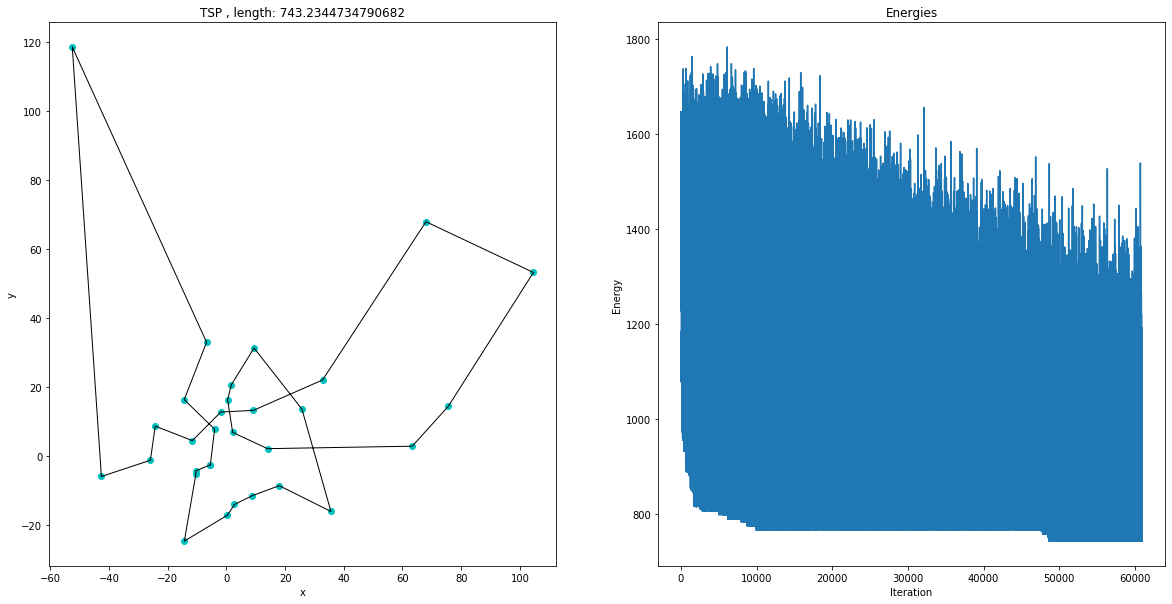

N =  30


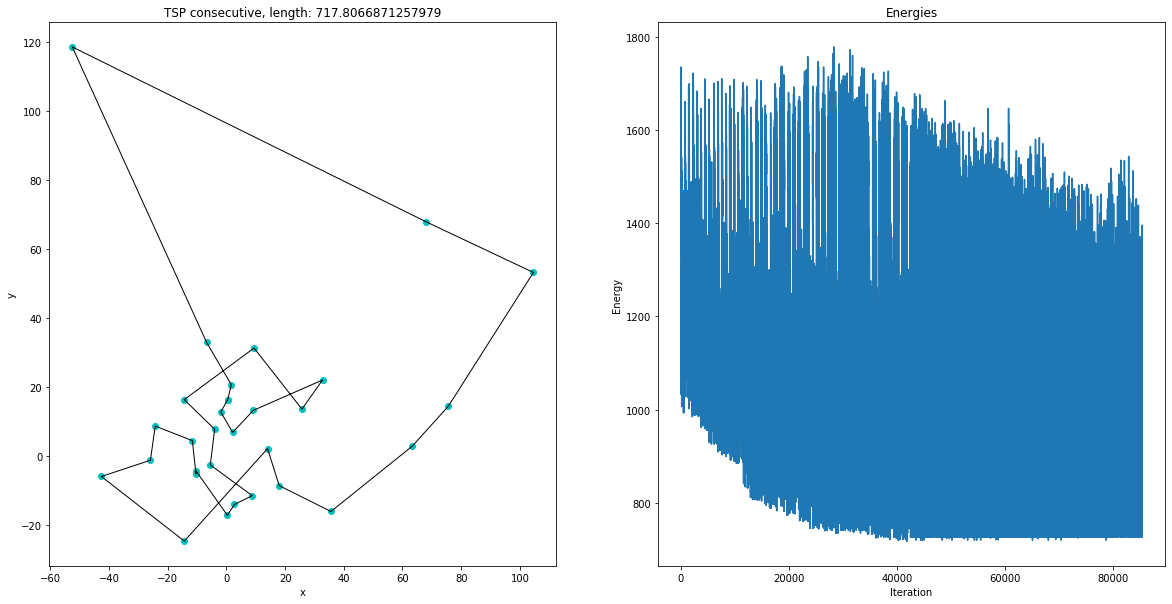

N =  30


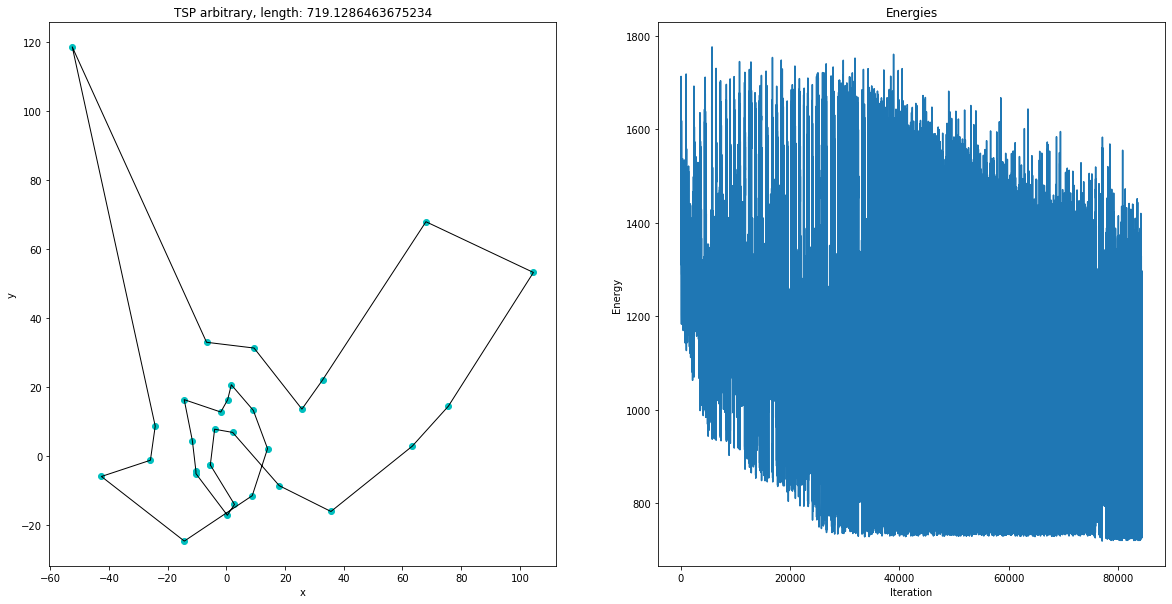

In [28]:
N = 30
points = generate_normal(N)
energies = []

simulated_annealing(f, temp=1000, show_random=False, name="")

energies = []
simulated_annealing(f_consecutive, temp=1000, show_random=False, name="consecutive")

energies = []
simulated_annealing(f_arbitrary, temp=1000, show_random=False, name="arbitrary")

### Dla dziewięciu odseparowanych grup punktów i liczby punktów N = 30

N =  30


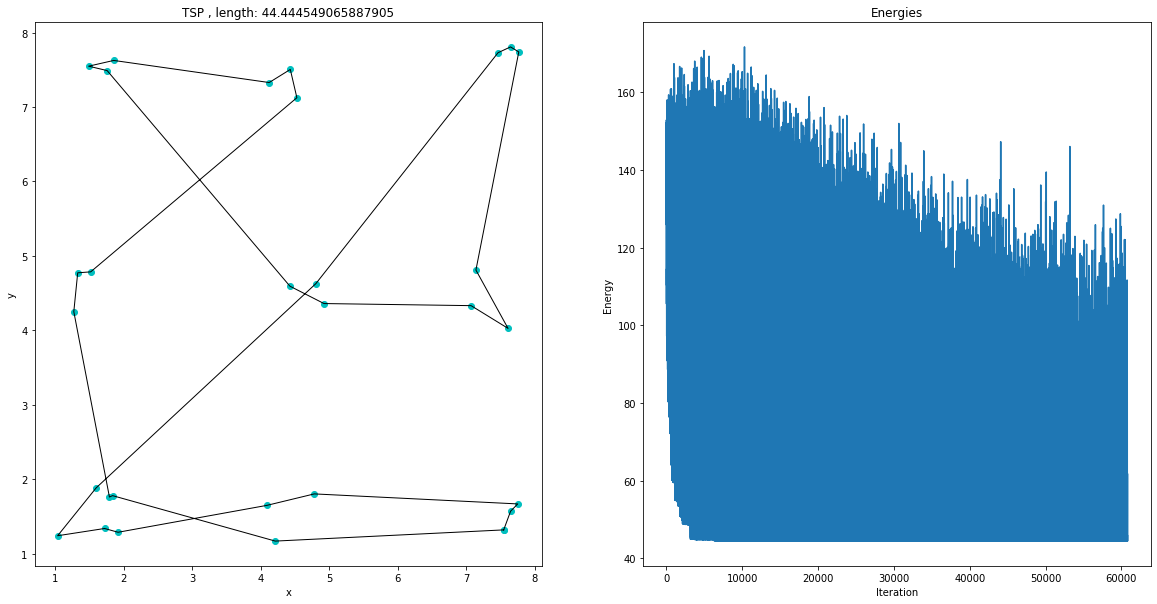

N =  30


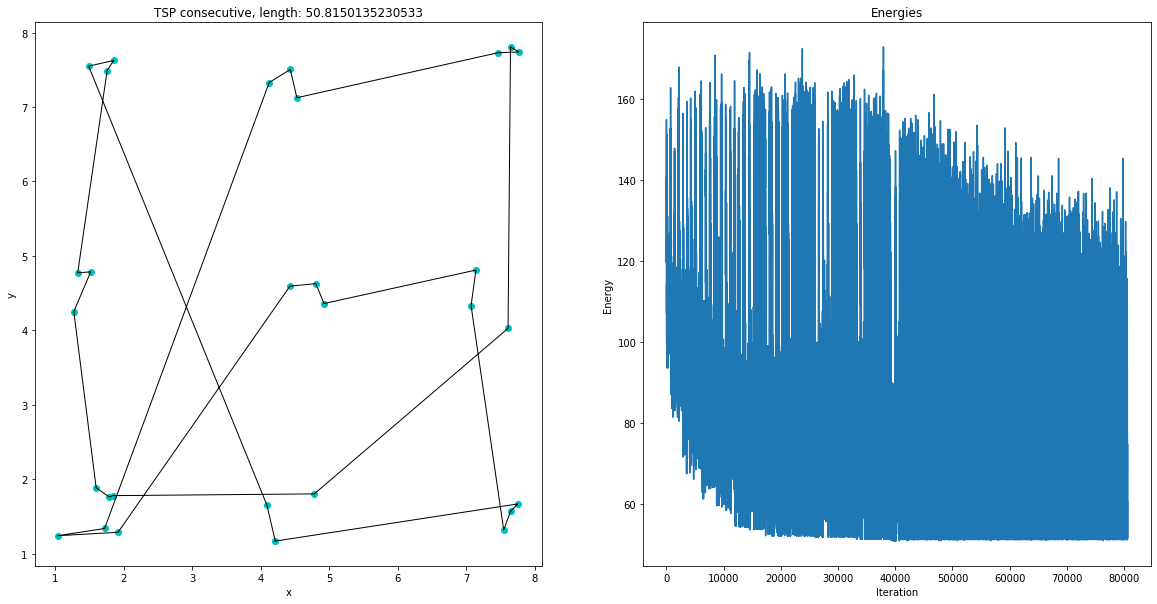

N =  30


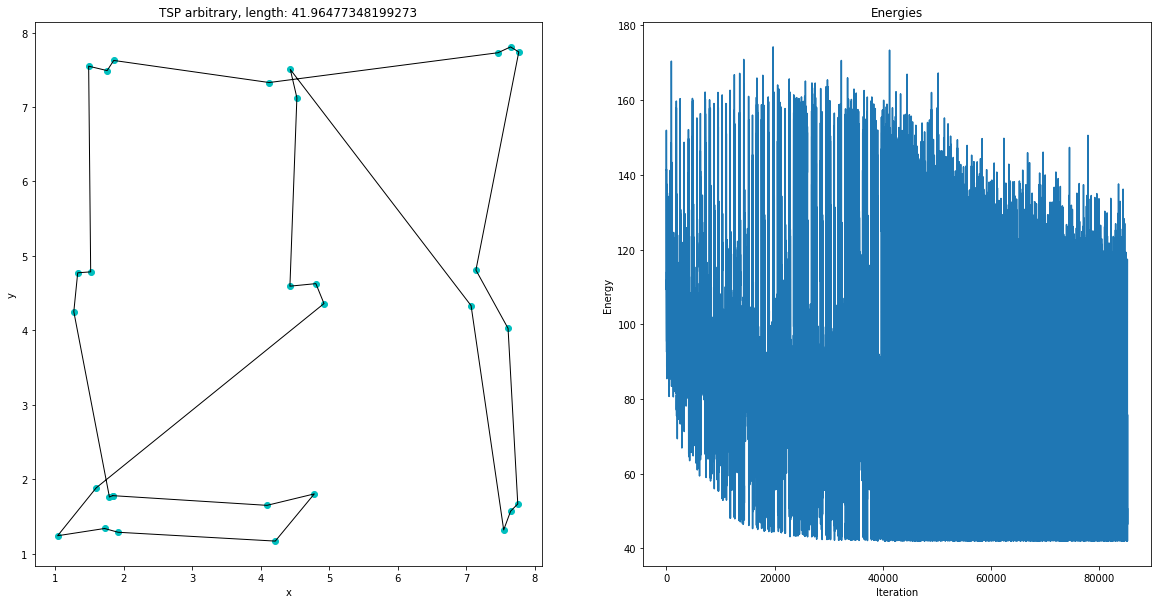

In [29]:
N = 30
points = generate_nine(N)
energies = []
simulated_annealing(f, temp=1000, show_random=False, name="")

energies = []
simulated_annealing(f_consecutive, temp=1000, show_random=False, name="consecutive")

energies = []
simulated_annealing(f_arbitrary, temp=1000, show_random=False, name="arbitrary")

## b) Wpływ temperatury
### Dla rozkładu jednostajnego i liczby punktów N = 30

N =  30


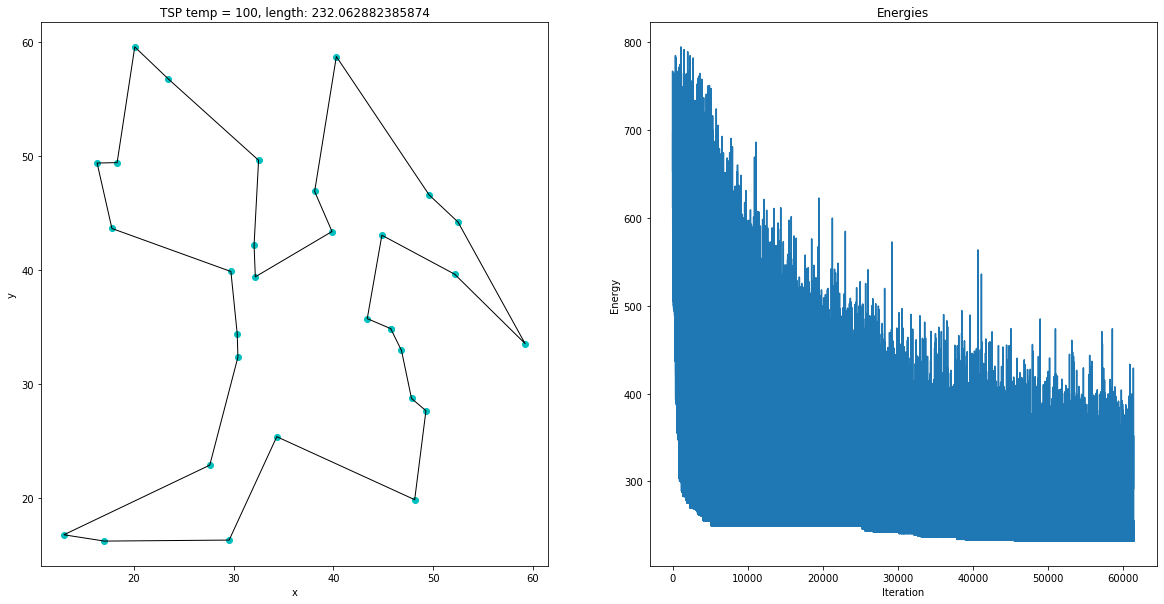

N =  30


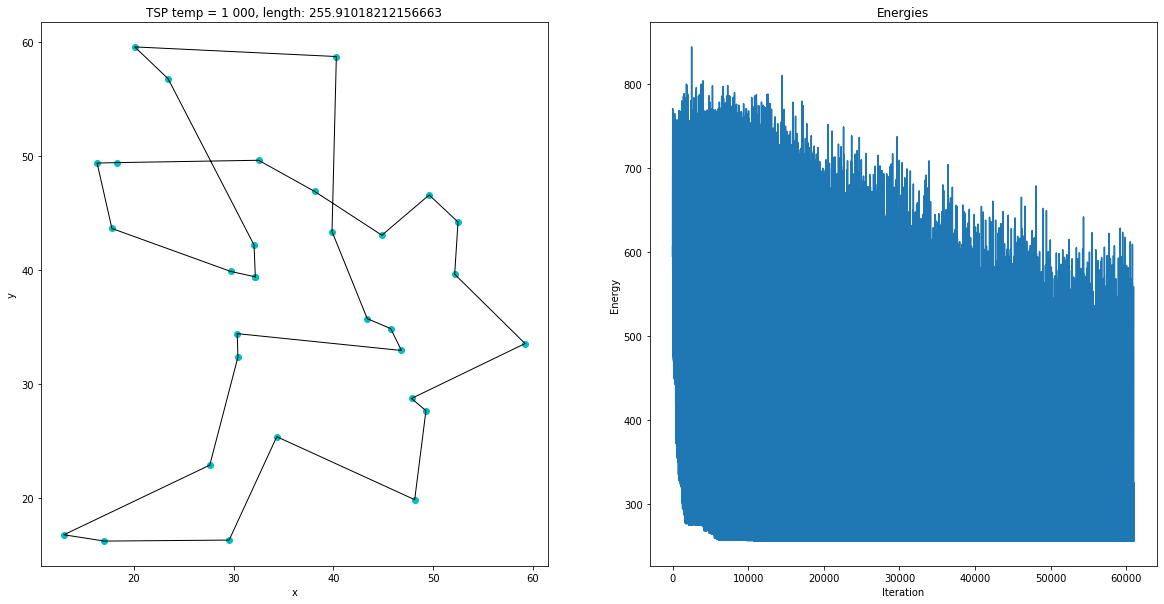

N =  30


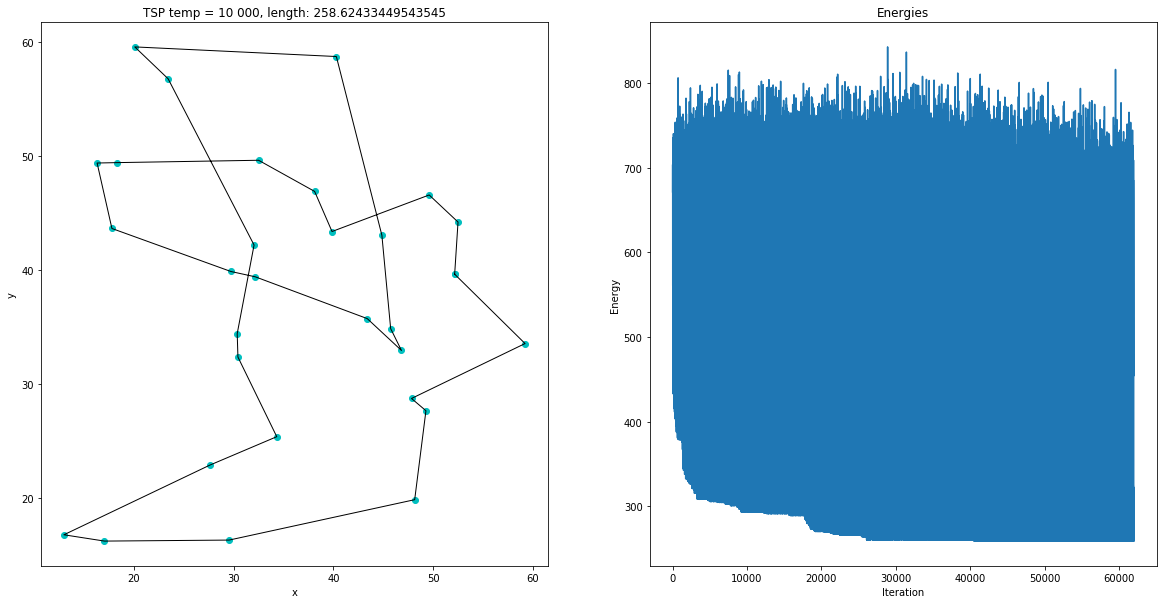

In [36]:
N = 30
points = generate_uniform(N, 10, 60)

energies = []
simulated_annealing(f, temp=100, show_random=False, name="temp = 100")

energies = []
simulated_annealing(f, temp=1000, show_random=False, name="temp = 1 000")

energies = []
simulated_annealing(f, temp=10000, show_random=False, name="temp = 10 000")

### Dla rozkładu normalnego z czterema różnymi grupami parametrów i liczby punktów N = 30

N =  30


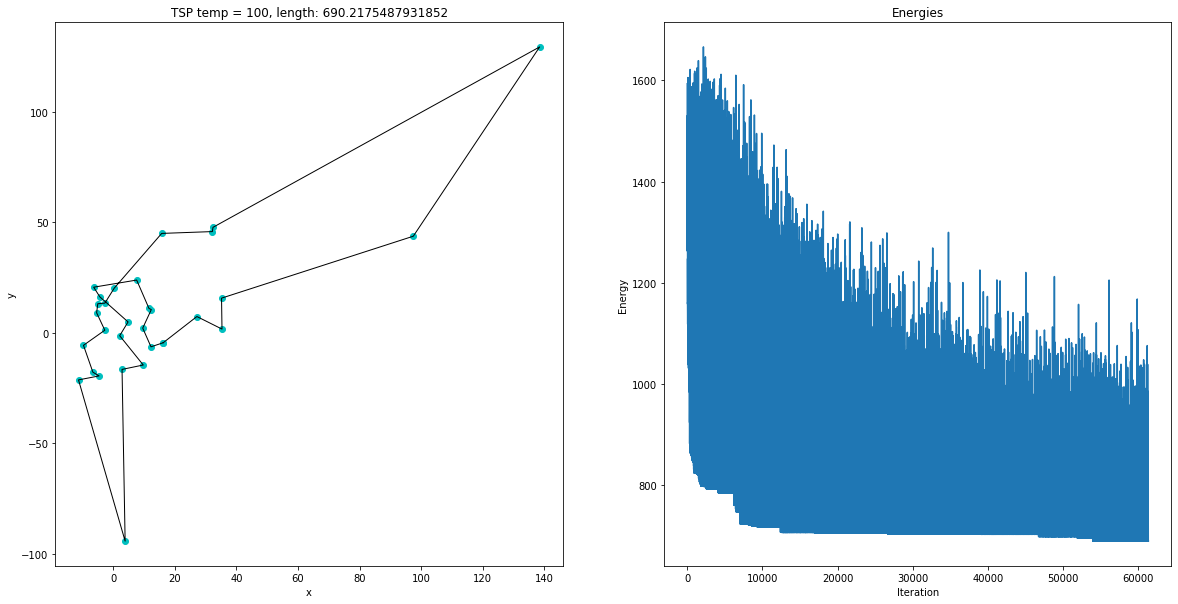

N =  30


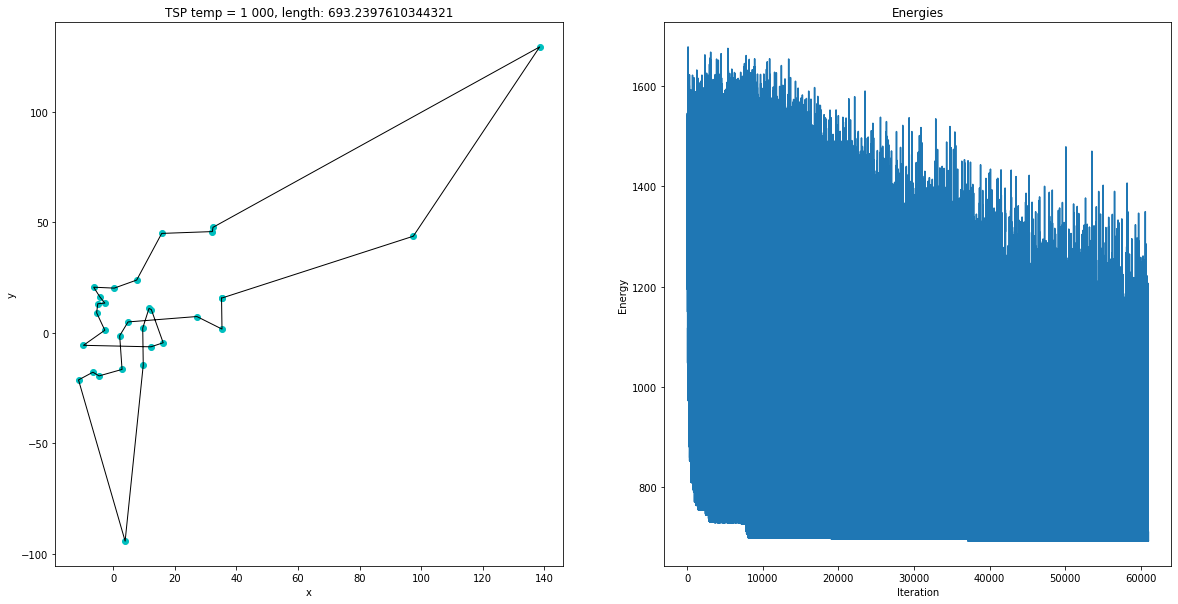

N =  30


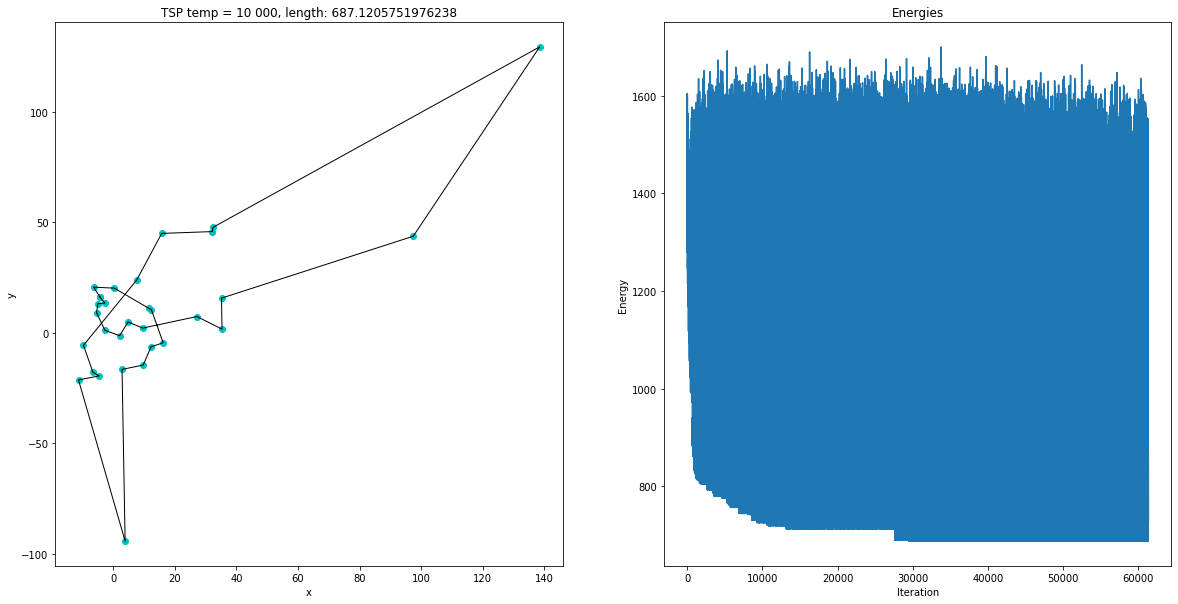

In [42]:
N = 30
points = generate_normal(N)
energies = []

energies = []
simulated_annealing(f, temp=100, show_random=False, name="temp = 100")

energies = []
simulated_annealing(f, temp=1000, show_random=False, name="temp = 1 000")

energies = []
simulated_annealing(f, temp=10000, show_random=False, name="temp = 10 000")

### Dla dziewięciu odseparowanych grup punktów i liczby punktów N = 30

N =  30


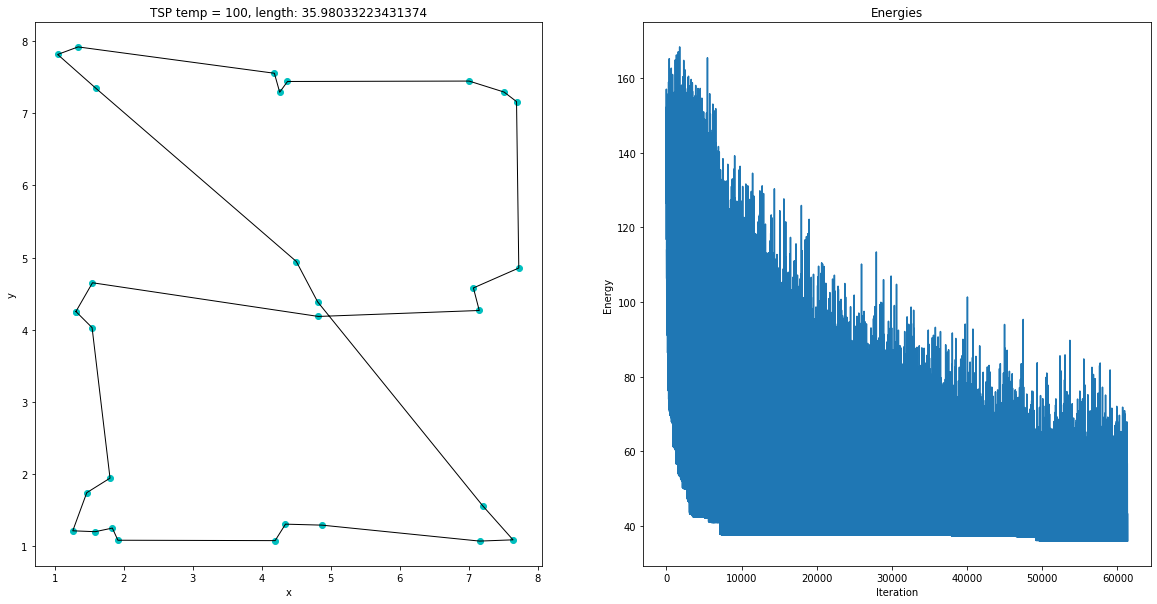

N =  30


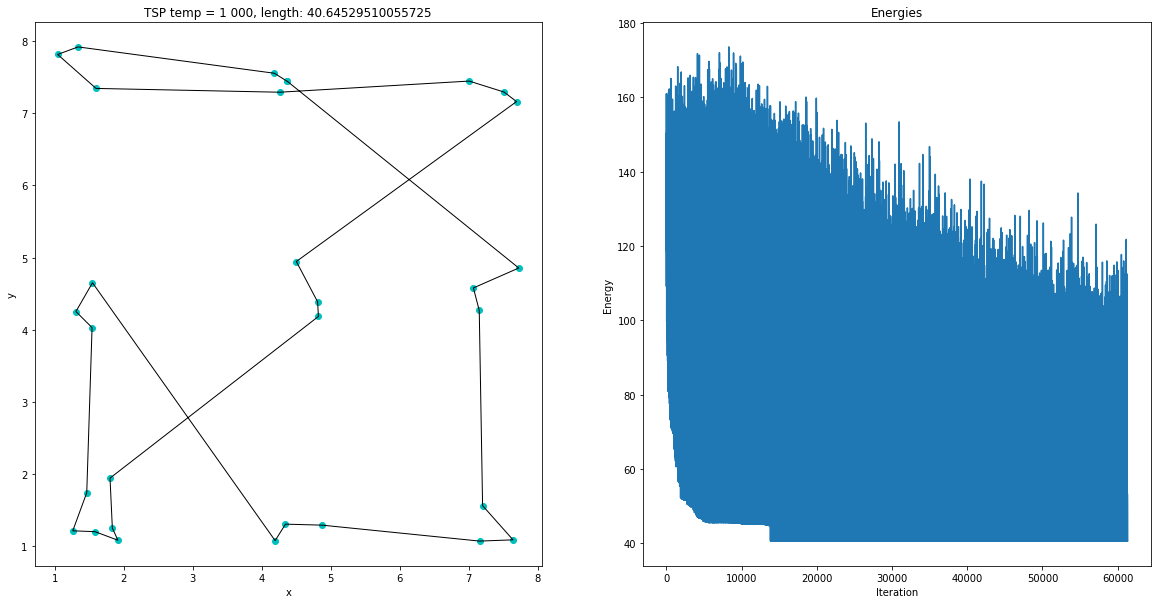

N =  30


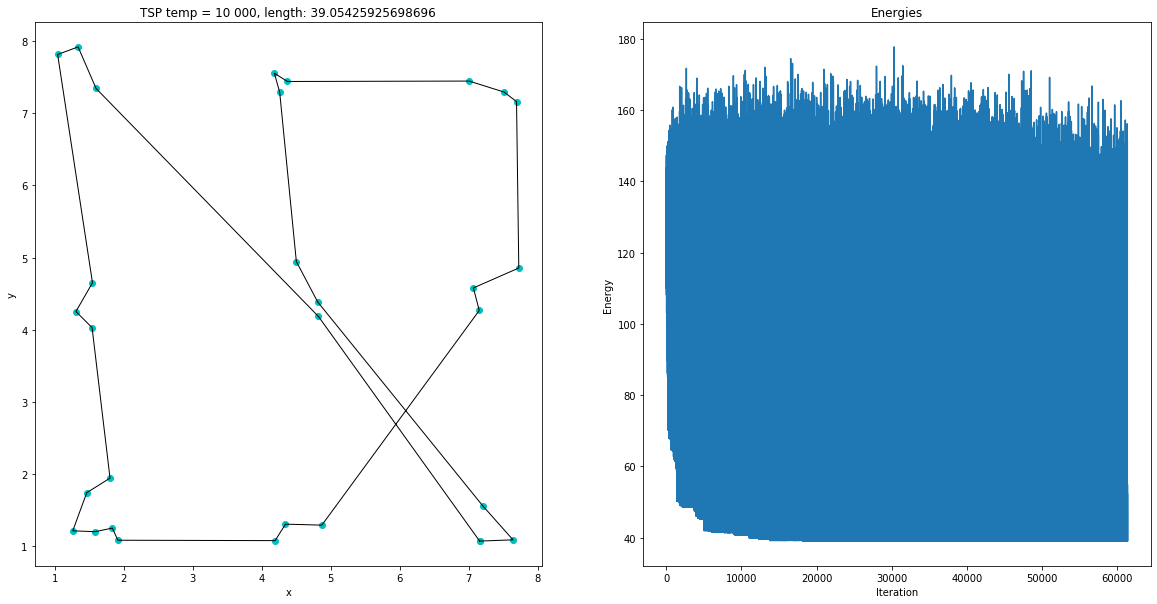

In [46]:
N = 30
points = generate_nine(N)
energies = []

energies = []
simulated_annealing(f, temp=100, show_random=False, name="temp = 100")

energies = []
simulated_annealing(f, temp=1000, show_random=False, name="temp = 1 000")

energies = []
simulated_annealing(f, temp=10000, show_random=False, name="temp = 10 000")

## Wnioski:

Metoda *arbitrary swap* daje lepsze rezultaty niż metoda *consecutive swap* w większości przypadków. Może to być spowodowane faktem, że druga z metod nie zmienia stosunkowo dużo rozwiązania w porównaniu do pierwszej. Zmieniając kolejnością sąsiednie wierzchołki zmiana nie jest, aż tak widoczna.

Parametrem algorytmu, który ma wpływ na prawdopodobieństwo wyboru gorszego rozwiązania jest parametr przeniesiony bezpośrednio z podstaw termodynamicznych algorytmu, czyli temperatura. Im wyższa, tym prawdopodobieństwo wyboru gorszego rozwiązania jest większe. Im niższa, tym algorytm jest bardziej zbliżony w działaniu do typowych metod iteracyjnych, co można zauważyć na wykresach energii i długościach ścieżek w zależności od temperatury. Przeważnie im wyższą temperaturę stosowano, tym długość ścieżki się zwiększała. 

Fakt ten znajduje odzwierciedlenie w drugim ważnym aspekcie algorytmu symulowanego wyżarzania czyli w powolnym ochładzaniu.
Na początku działania algorytmu temperatura jest wysoka, dzięki czemu algorytm może bardzo często zmieniać konfigurację rozwiązania, niejednokrotnie wybierając rozwiązanie gorsze. Wraz z kolejnymi iteracjami algorytmu temperatura spada i wybierane są częściej rozwiązania lepsze. Pod koniec pracy algorytmu, temperatura jest na tyle niska, że prawdopodobieństwo wyboru gorszego rozwiązania jest bliskie zeru. 

Im dłużej algorytm może działać zanim zostanie osiągnięte kryterium zatrzymania tym lepsze może uzyskać wyniki. Ma to jednak wpływ na znaczne wydłużenie czasu jego działania.

Podsumowując mimo, że symulowane wyżarzanie nie gwarantuje pozostania przy najlepszym rozwiązaniu to osiągą zadowalające efekty. Ma wiele zastosowań, a jednym z nich jest rozwiązywanie problemu komiwojażera.